In [1]:
import numpy as np
import sympy
from qiskit import *
from qiskit import QuantumCircuit
from qiskit.qasm2 import dumps

from itertools import combinations
from qiskit import Aer, QuantumCircuit
from qiskit.quantum_info import Operator
from qiskit.circuit import Parameter,ParameterVector
from qiskit.utils import algorithm_globals


In [2]:
n_qubits = 2
n_repeats = 1
qubits = QuantumRegister(n_qubits)

In [3]:
def rotate_layer(qubits,param_prefix):
    qc = QuantumCircuit(qubits)
    params = ParameterVector(param_prefix, length=n_qubits*3)
    for i in range(n_qubits):
        qc.rz(params[i], qubits[i])
        qc.rx(params[i+n_qubits], qubits[i])
        qc.rz(params[i+2*n_qubits], qubits[i])

    return qc

In [4]:
def entangle_layer(qubits,param_prefix):
    qc = QuantumCircuit(qubits)
    
    n_comb = int(n_qubits*(n_qubits-1)/2)
    params = ParameterVector(param_prefix, n_comb)
    
    comb = combinations(qubits, 2)
    index=0
    for i in comb:
        qc.rxx(params[index],i[0], i[1])
        index += 1

    return qc

In [5]:
def whole_circuit(qubits,repeats):
    qc = QuantumCircuit(qubits)
    for i in range(repeats):
        qc.compose(rotate_layer(qubits,"r"+str(i)), qubits, inplace=True)
        qc.compose(entangle_layer(qubits,"e"+str(i)), qubits, inplace=True)
    return qc
    

/opt/.qbraid/environments/qbraid_000000/pyenv/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


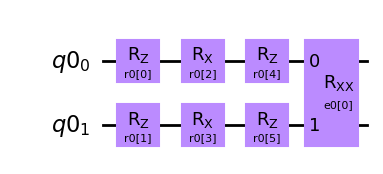

In [6]:
circuit = whole_circuit(qubits,n_repeats)
circuit.draw('mpl')

In [7]:
from qiskit.algorithms.optimizers import OptimizerResult

from qiskit.algorithms.optimizers import L_BFGS_B, COBYLA
from qiskit_aer import StatevectorSimulator
from qiskit.quantum_info import Statevector
import qiskit.quantum_info as qi

intermediate_cost = []
intermediate_params = []

def cost(params, target, circ):
    '''
    target: dict
            count_dictionary obtained from the probe circuit
    params: 
    '''
    cir = circ.assign_parameters(params)
    result = qi.Statevector.from_instruction(cir).probabilities_dict()
    cost = 0
    for key, value1 in target.items():
        if key in result.keys():
            value2 = result[key]
        else:
            value2 = 0
        cost += ((value1-value2)**2)
    
    intermediate_cost.append(cost)
    intermediate_params.append(params)
    return cost

def callback_func(params, target):
    cost_value = cost(params, target)  # Calculate the cost at the current iteration
    intermediate_cost.append(cost_value)
    intermediate_params.append(params)
 


/tmp/ipykernel_2695/2139523383.py:1: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import OptimizerResult


In [8]:
probe = {'0': 0.155, '1': 0.755, '3': 0.09} #key9
for i in range(2**n_qubits):
    if str(i) not in probe.keys():
        probe[str(i)] = 0
target = {}
for key,value in probe.items():
    tar_key = bin(2**n_qubits - int(key) - 1)[2:]
    target_key = '0'*(n_qubits-len(tar_key))+tar_key
    target[target_key] = value
    
target

{'11': 0.155, '10': 0.755, '00': 0.09, '01': 0}

In [9]:
from scipy.optimize import minimize
n_params = (n_qubits*3+int(n_qubits*(n_qubits-1)/2))*n_repeats
params_0 = np.ones(n_params)
out = minimize(cost, x0=params_0, args = (target, circuit) ,method="L-BFGS-B", options={'maxiter':1000})
#cost(out.jac,target,circuit)
intermediate_params[-1]

array([0.33785725, 1.00000003, 1.0000001 , 0.77023801, 2.36115964,
       1.87476781, 0.26590403])

In [10]:
intermediate_cost[-1]

2.233456766529973e-09

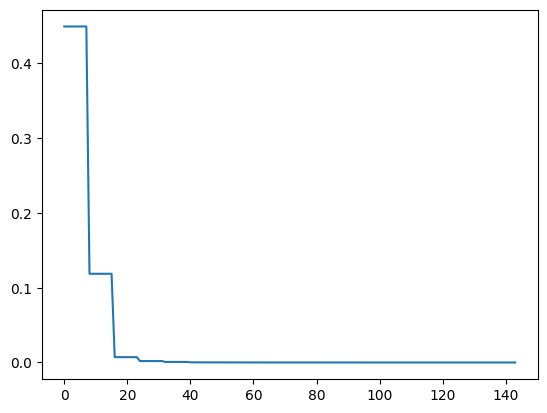

In [11]:
import matplotlib.pyplot as plt
plt.plot(intermediate_cost)

/opt/.qbraid/environments/qbraid_000000/pyenv/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


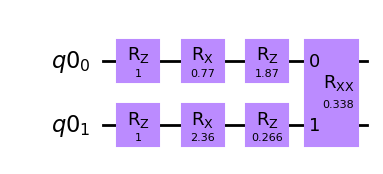

In [12]:
trained_params = intermediate_params[-1]
final_circ = whole_circuit(qubits,n_repeats).assign_parameters(trained_params)
inverse_final_circ = whole_circuit(qubits,n_repeats).assign_parameters(trained_params).inverse()
final_circ.draw('mpl')

/opt/.qbraid/environments/qbraid_000000/pyenv/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


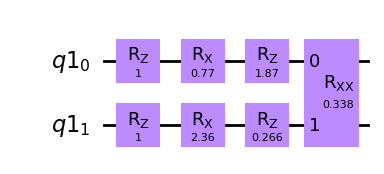

In [21]:
inverse_final_circ.draw('mpl')

In [13]:
result_f = qi.Statevector.from_instruction(final_circ).probabilities_dict()
result_f

{'00': 0.08999249909012695,
 '01': 3.986126868542487e-05,
 '10': 0.7549781331710894,
 '11': 0.15498950647009868}

In [17]:
import server
server = server.Server()

In [18]:
from qbraid.api import QbraidSession
from server import Server

session = QbraidSession(api_key="80tk7wzbi8v")
server = Server(qbraid_session=session)

In [19]:
server.state()

{'team': 'lame_attack',
 'totalAvgScore': 0.12045833333333333,
 'topVaultScores': [0.8, 0, 0, 0, 0, 0.499, 0, 0, 0, 0.746, 0.2005, 0, 0],
 'probesRemaining': [15, 18, 18, 18, 18, 13, 18, 18, 18, 14, 18, 18, 18],
 'attacksRemaining': [20, 20, 20, 20, 20, 7, 20, 20, 20, 14, 13, 20, 20],
 'reminder': 'Vault index 0 is a test vault, and does not count towards your final score.'}

In [20]:
#attack_circ = inverse_final_circ.qasm()
#server.probe(vault_index=9, circuit=attack_circ)

RequestsApiError: HTTPSConnectionPool(host='api.qbraid.com', port=443): Max retries exceeded with url: /api/iquhack/ionq/probe (Caused by ResponseError('too many 500 error responses'))